In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, dataloader
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from datagen import *

c:\Users\matti\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Creating dataset for first problem

First problem is seeing how the RNN trains to just add a list of numbers in time together

In [2]:
n_data = 1000
t_steps = 10

# data,labels = datagen_full_sum(n_data,t_steps,normalize=True)
data,labels = datagen_timewise_labels(n_data,t_steps,2)
# print(data[1],labels[1])

In [3]:
class Datamodel(Dataset):
    def __init__(self,time_pos_points,labels):
        self.x = time_pos_points
        self.y = labels
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

BATCH_SIZE = 16

training_data = Datamodel(data,labels)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
hidden_size = 1
input_size = 1
output_size = 1

# model = torch_RNN1(input_size,t_steps,output_size,hidden_size,lr=0.001,irnn=False)
model = torch_RNN_timewise(input_size,t_steps,output_size,hidden_size,lr=0.001,irnn=False)
_ = model.train(training_loader,epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 2

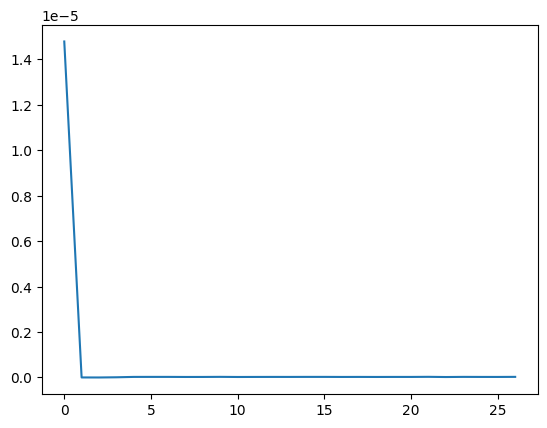

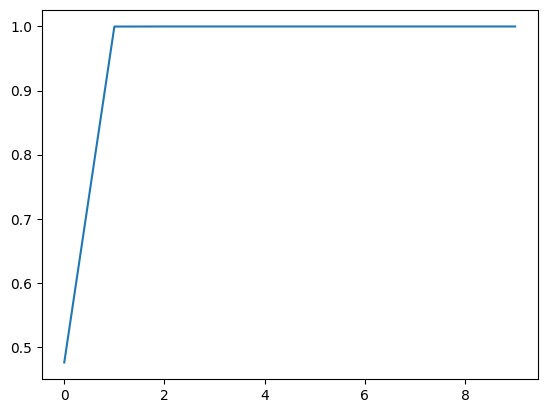

In [ ]:
losses = np.array(model.losses)
loss_data_avgd = losses.reshape(30,-1).mean(axis=1)
# plt.plot(losses[int(len(losses)//3):])
plt.plot(loss_data_avgd[3:])
plt.show()
train_accs = np.array(model.accs)
acc_data_avgd = train_accs.reshape(10,-1).mean(axis=1)
plt.plot(acc_data_avgd)

In [ ]:
model(data[0:15])

tensor([1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001,
        1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001],
       grad_fn=<SqueezeBackward0>)

In [ ]:
model.rnn.weight_hh_l0
# model.rnn.weight_ih_l0
# model.rnn.bias_ih_l0
# model.rnn.bias_hh_l0

Parameter containing:
tensor([[1.0000]], requires_grad=True)